# Restoring Color to Greyscale Images

In [1]:
import image
import os
import random
import numpy as np
import scipy as sp
import time

from sklearn import linear_model
from sklearn import ensemble
from sklearn import naive_bayes

import lasagne
import theano
import theano.tensor as T

%matplotlib inline
from IPython.core.pylabtools import figsize
import matplotlib.pyplot as plt
from matplotlib import cm
figsize(16, 4)

In [2]:
imdir = "images/raw"
handles = os.listdir(imdir)
random.shuffle(handles)
print "Found {l} image handles".format(l=len(handles))

Found 126905 image handles


## Playing Around with Shallow Regressors

In [3]:
def ShowColorAndGreyscale(color, grey):
    _, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(color)
    ax2.imshow(grey, cmap=cm.gray)
    plt.show()

    
def ShowChannels(color, grey):
    _, axes = plt.subplots(1, 3)
    for ch in xrange(color.shape[2]):
        ax = axes[ch]
        ax.imshow(color[:, :, ch:ch + 1].reshape(
            grey.shape), cmap=cm.gray)
    plt.show()


def GeneratePatches(grey, stride):
    ymax, xmax = grey.shape
    stepmin, stepmax = ((stride - 1) / -2, stride / 2)
    steps = range(stepmin, stepmax + 1)
    trimmed_shape = (ymax - 2 * stepmax, xmax - 2 * stepmax)
    
    # convolutional patches for training
    # there's probably a numpy one-liner for this, but I don't know it
    patches = []
    for xoff in steps:
        for yoff in steps:
            patches.append(
                grey[stepmax + yoff:ymax - stepmax + yoff,
                     stepmax + xoff:xmax - stepmax + xoff])
    patches = np.stack(patches, axis=2)
    plt.imshow(patches.mean(axis=2), cmap=cm.gray)
    plt.show()
    return patches, trimmed_shape, len(steps) ** 2, xmax, ymax, stepmax


def RestoreImageFromFlattenedPatches(ch_clfs, flattened_patches, shape):
    channels = []
    for clf in ch_clfs:
        channels.append(clf.predict(flattened_patches).reshape(
            *shape))
    restored = np.stack(channels, axis=2)
    plt.imshow(restored)
    plt.show()
    return restored


def RestoreImage(ch_clfs, grey, stride):
    patches, trimmed_shape, num_features, _, _, _ = GeneratePatches(
        grey, stride)
    flattened_patches = patches.reshape(
        np.product(trimmed_shape), num_features)
    return RestoreImageFromFlattenedPatches(
        ch_clfs, flattened_patches, trimmed_shape)
    
    
def ModelChannels(color, grey, stride, clf_class, clf_kwargs):
    patches, trimmed_shape, num_features, xmax, ymax, stepmax = GeneratePatches(
        grey, stride)
    flattened_patches = patches.reshape(
        np.product(trimmed_shape), num_features)

    # models for each channel
    ch_clfs = []
    for ch in xrange(color.shape[2]):
        target_luminosities = color[
            stepmax:ymax - stepmax,
            stepmax:xmax - stepmax,
            ch].reshape(np.product(trimmed_shape))
        clf = clf_class(**clf_kwargs)
        clf.fit(flattened_patches, target_luminosities)
        ch_clfs.append(clf)
    
    RestoreImageFromFlattenedPatches(
        ch_clfs, flattened_patches, trimmed_shape)
    
    return ch_clfs


def ProcessImage(color, grey, stride,
                 clf_class=linear_model.LinearRegression, clf_kwargs={}):
    color = image.DownsampledPatch(color, 100, 100)
    grey = image.DownsampledPatch(grey, 100, 100)
    ShowColorAndGreyscale(color, grey)
    ShowChannels(color, grey)
    ch_clfs = ModelChannels(color, grey, stride, clf_class, clf_kwargs)
    return ch_clfs


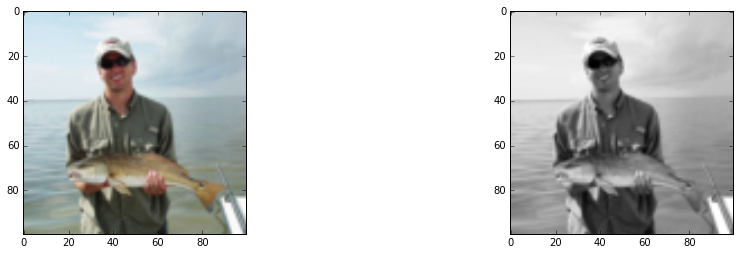

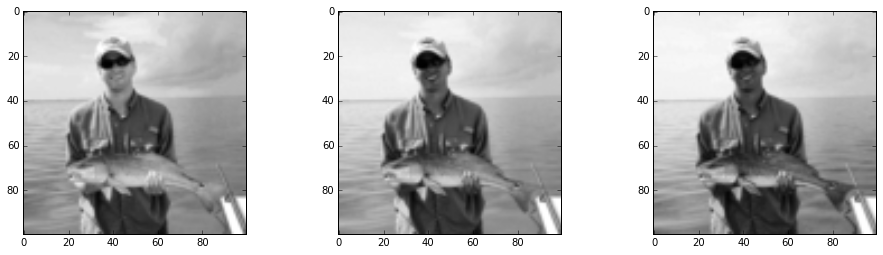

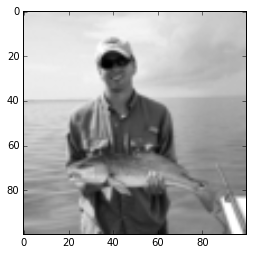

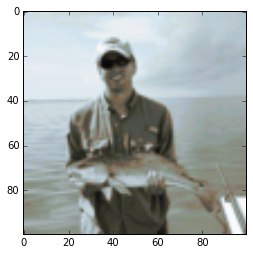

In [4]:
color, grey = image.LoadColorAndGreyscaleImages(
    os.path.join(imdir, handles[random.randint(0, len(handles))]))

ch_clfs = ProcessImage(
    color, grey, 1,
    clf_class=naive_bayes.GaussianNB)

## Neural Networks with Lasagne & Theano

based on the lasagne example code at https://github.com/Lasagne/Lasagne/blob/master/examples/mnist.py.

This is embarassingly copy-pasty. Will likely become more distinct as I grow to understand what I'm doing.


In [5]:
HEIGHT = 100
WIDTH = 100

fullsize = (
    image.LoadColorAndGreyscaleImages(os.path.join(imdir, h))
    for h in handles[:20000])

downsampled = [
    (image.DownsampledPatch(c, HEIGHT, WIDTH),
     image.DownsampledPatch(g, HEIGHT, WIDTH))
    for c, g in fullsize
    if c is not None and g is not None]

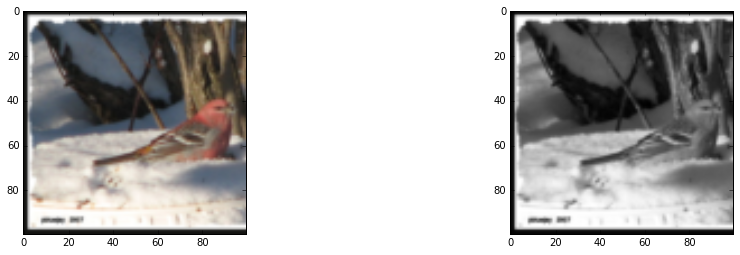

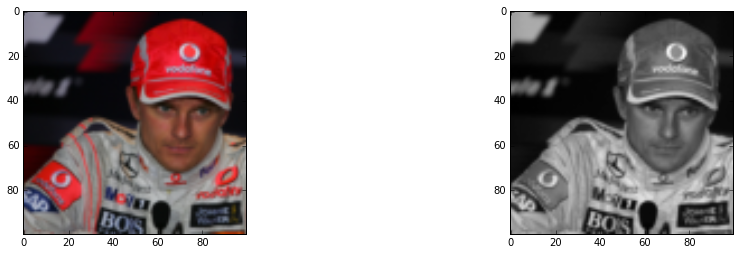

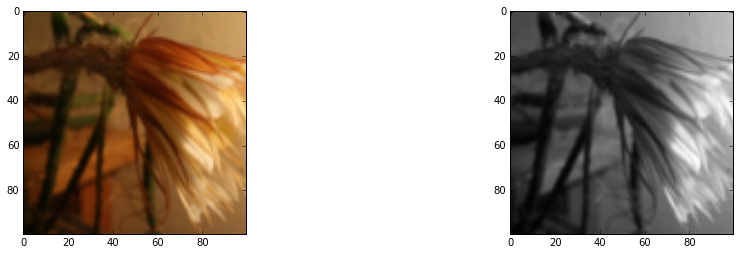

In [6]:
for c, g in downsampled[:3]:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.imshow(c)
    ax2.imshow(g, cmap=cm.gray)

In [7]:
test_set_size = len(downsampled) / 10
test = downsampled[:test_set_size]
val = downsampled[test_set_size:2 * test_set_size]
train = downsampled[2 * test_set_size:10 * test_set_size]

X_test = np.array([g.reshape(HEIGHT, WIDTH, 1).T for _, g in test])
y_test = np.array([c.T.astype(np.float64) / (c.T.sum(axis=0) + 1) for c, _ in test])
#y_test = np.array([c.T for c, _ in test])
X_val = np.array([g.reshape(HEIGHT, WIDTH, 1).T for _, g in val])
y_val = np.array([c.T.astype(np.float64) / (c.T.sum(axis=0) + 1) for c, _ in val])
#y_val = np.array([c.T for c, _ in val])
X_train = np.array([g.reshape(HEIGHT, WIDTH, 1).T for _, g in train])
y_train = np.array([c.T.astype(np.float64) / (c.T.sum(axis=0) + 1) for c, _ in train])
#y_train = np.array([c.T for c, _ in train])

In [8]:
class ProportionNormalizationLayer(lasagne.layers.Layer):
    def get_output_for(self, inp, **kwargs):
        return inp * inp.shape[1] / T.sum(inp, axis=1)


def BuildNet(input_var=None, height=HEIGHT, width=WIDTH):
    # We start with a single channel image, extract some number (>> 3) of
    # convolutional kernels, then collapse back down to 3 channels representing
    # red, green, and blue. We're not trying to predict luminosities at the
    # output layer: rather, we want the ratio of the activations of the output
    # layers to 
    l_in = lasagne.layers.InputLayer(
        shape=(None, 1, height, width),
        input_var=input_var)
    l_conv1 = lasagne.layers.Conv2DLayer(
        l_in,
        num_filters=12,
        filter_size=(5, 5),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform())
    l_conv2 = lasagne.layers.Conv2DLayer(
        l_conv1,
        num_filters=5,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform())
    l_conv3 = lasagne.layers.Conv2DLayer(
        l_conv2,
        num_filters=3,
        filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.sigmoid,
        W=lasagne.init.GlorotUniform())
    #l_out = ProportionNormalizationLayer(l_conv3)
    return l_conv3

In [14]:
def Minibatches(inputs, targets, batch_size, trim):
    assert len(inputs) == len(targets)
    for i in range(0, len(inputs) - batch_size + 1, batch_size):
        yield (i,
               inputs[i:i + batch_size],
               targets[i:i + batch_size, :, trim:-trim, trim:-trim])


def CreateTheanoExprs(num_epochs=1, height=HEIGHT, width=WIDTH):
    # Inputs and outputs.
    # Input greyscale images need to be explicit H x W x 1 tensors of rank 3.
    # Leaving them as H x W matrices of rank 2 confuses lasagne's
    # convolutional logic.
    input_var = T.tensor4("inputs")
    target_var = T.tensor4("targets")

    # Build network.
    net = BuildNet(
        input_var=input_var,
        height=height,
        width=width)

    # Loss expression.
    # Since we don't have stochastic dropout, we can use the same loss
    # expr for training and validation. If we want to add a dropout layer,
    # then we need a separate loss expression for validation where stochastic
    # elements are explicitly frozen & dropout is disabled.
    prediction = lasagne.layers.get_output(net)
    loss = lasagne.objectives.squared_error(prediction, target_var).mean()

    # Weight updates during training.
    params = lasagne.layers.get_all_params(net, trainable=True)
    updates = lasagne.updates.nesterov_momentum(
        loss,
        params,
        learning_rate=0.03,
        momentum=0.9)

    # Theano function to train a mini-batch.
    train_fn = theano.function(
        [input_var, target_var],
        loss,
        updates=updates,
        name="Train")

    # Thano function to evaluate / validate on an input.
    # The difference between this and the training function is that the
    # test / validation function does not apply weight updates.
    val_fn = theano.function(
        [input_var, target_var],
        [prediction, loss],
        name="Evaluate")
    
    return net, train_fn, val_fn


def Test(batch_size, trim, X_test, y_test, net, val_fn):
    mark = time.time()
    test_errs = []
    iterator = Minibatches(X_test, y_test, batch_size, trim)
    for i, inputs, targets in iterator:
        print "Testing batch starting at {i}...".format(i=i)
        _, err = val_fn(inputs, targets)
        test_errs.append(err)
    test_err = np.mean(test_errs)
    test_time = time.time() - mark
    print ("\nTesting completed in {test_time:.2f} seconds. "
           "Test error = {t_err:.4f}.").format(
               test_time=test_time,
               t_err=test_err)
    return test_err


def Train(num_epochs, batch_size, trim,
          X_train, y_train, X_val, y_val, X_test, y_test,
          net, train_fn, val_fn):
    # Record stats for each epoch
    epochs = []
    
    # Run through training data for each epoch
    for epoch in xrange(num_epochs):
        # Train
        mark = time.time()
        train_errs = []
        iterator = Minibatches(X_train, y_train, batch_size, trim)
        for i, inputs, targets in iterator:
            print "Training batch starting at {i}...".format(i=i)
            train_errs.append(train_fn(inputs, targets))
        train_err = np.mean(train_errs)
        train_time = time.time() - mark
        
        # Validate
        mark = time.time()
        val_errs = []
        iterator = Minibatches(X_val, y_val, batch_size, trim)
        for i, inputs, targets in iterator:
            print "Validating batch starting at {i}...".format(i=i)
            _, err = val_fn(inputs, targets)
            val_errs.append(err)
        val_err = np.mean(val_errs)
        val_time = time.time() - mark
        
        # Record & report metrics
        epochs.append((epoch, train_time, val_time, train_err, val_err))
        print ("\nFinished Epoch {epoch}:\n"
               "- training took {train_time:.2f} minutes\n"
               "- validation took {val_time:.2f} minutes\n"
               "- training error = {t_err:.4f}\n"
               "- validation error = {v_err:.4f}\n").format(
                   epoch=epoch,
                   train_time=train_time / 60,
                   val_time=val_time / 60,
                   t_err=train_err,
                   v_err=val_err)

    test_err = Test(batch_size, trim, X_test, y_test, net, val_fn)
    return epochs, net, test_err
    

In [10]:
theano_exprs = CreateTheanoExprs()

In [44]:
epochs, net, err = Train(
    0, 1000, 4,
    X_train, y_train, X_val, y_val, X_test, y_test,
    *theano_exprs)

Testing batch starting at 0...

Testing completed in 5.81 seconds. Test error = 0.0159.


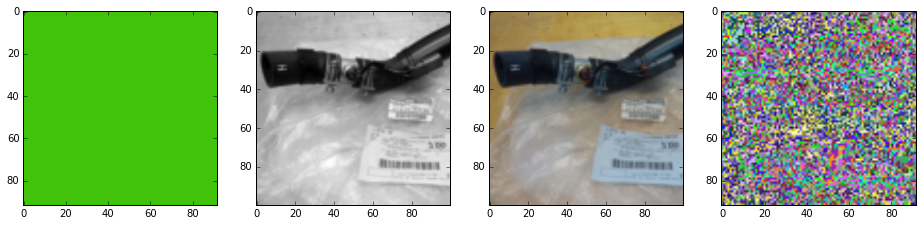

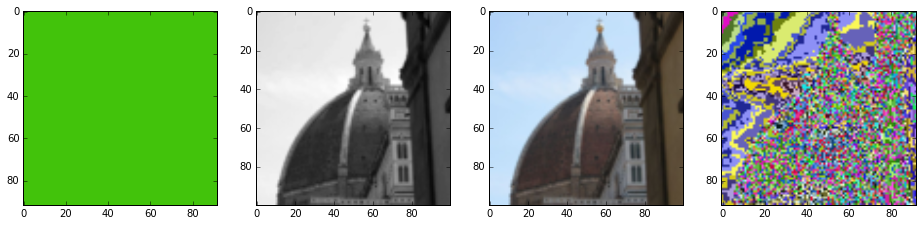

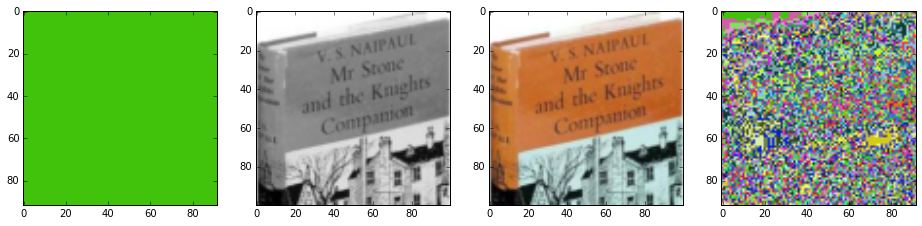

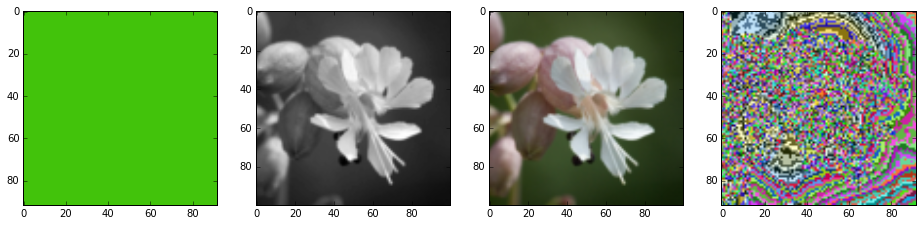

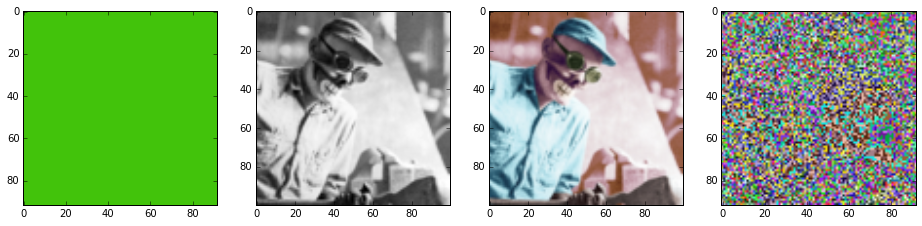

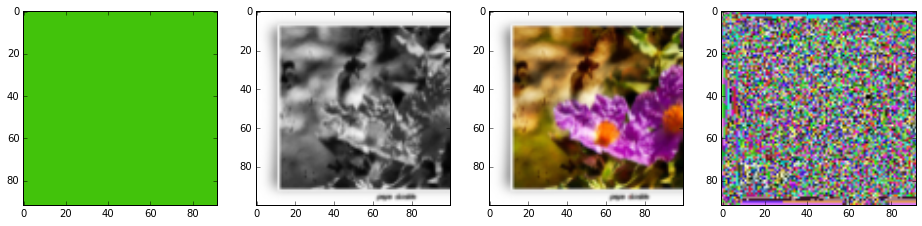

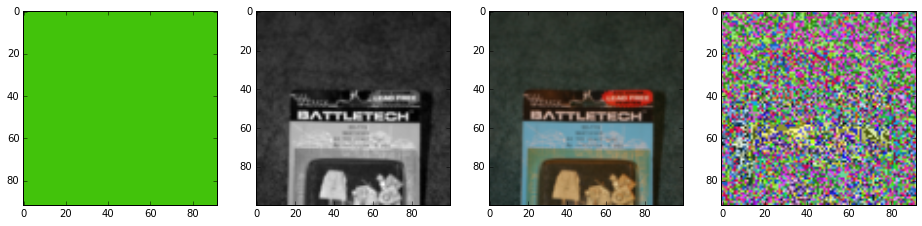

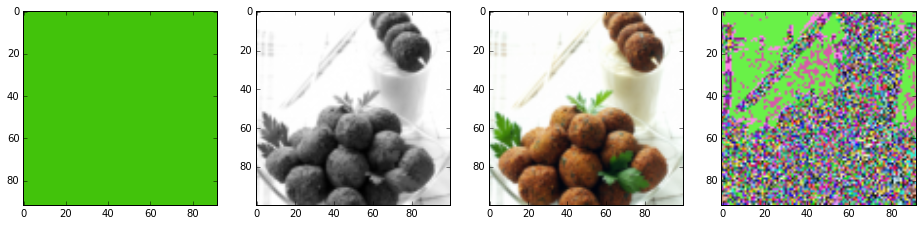

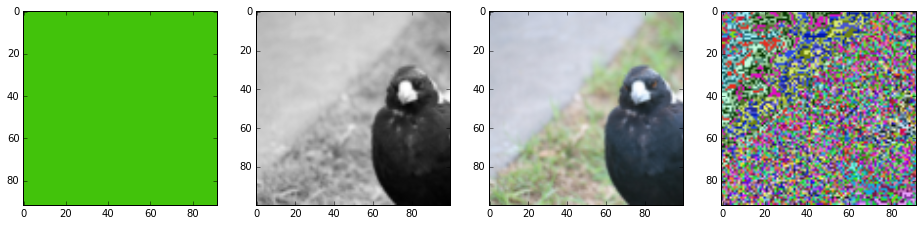

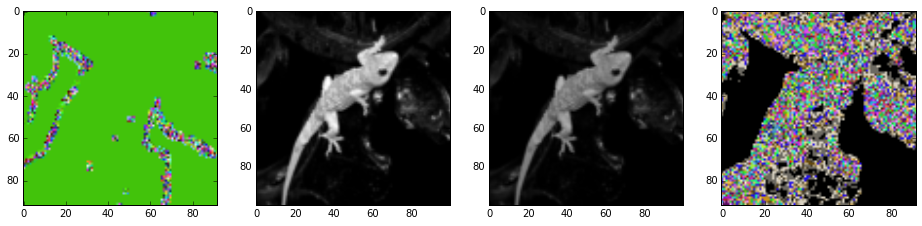

In [47]:
import random

eval_fn = theano_exprs[2]
indices = range(len(X_test))
random.shuffle(indices)

for i in indices[:10]:
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4)
    w, _ = eval_fn(
        X_test[i].reshape(1, 1, 100, 100),
        y_test[i].reshape(1, 3, 100, 100)[:, :, 4:-4, 4:-4])
    w = w.T.reshape(92, 92, 3)
    ch1 = X_test[i].T.reshape(100, 100)[4:-4, 4:-4]
    restoration = np.stack(
        [ch1 * w[:, :, 0],
         ch1 * w[:, :, 1],
         ch1 * w[:, :, 2]],
        axis=2)
    ax0.imshow(w * 255)
    ax1.imshow(test[i][1], cmap=cm.gray)
    ax2.imshow(test[i][0])
    ax3.imshow(restoration)
    plt.show()